In [460]:
import pandas as pd
import numpy as np
import matplotlib as plt
import seaborn as sns

from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn import tree
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

import scipy.stats as st
from sklearn.neighbors import LocalOutlierFactor
import matplotlib.pyplot as plt

from sklearn.model_selection import StratifiedKFold, KFold,RandomizedSearchCV, GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import make_scorer
from sklearn import tree
from sklearn.metrics import confusion_matrix, precision_recall_curve, roc_curve, recall_score, accuracy_score,f1_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import StratifiedKFold, KFold,RandomizedSearchCV,GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import make_scorer,f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
import sklearn as sk

from sklearn import svm
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier

from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_text

from six import StringIO
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydotplus
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report , f1_score, accuracy_score, recall_score

from sklearn.model_selection import StratifiedKFold, KFold,RandomizedSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import make_scorer

import pickle

# Clasificacion

## Creacion de target

Para esta tarea se debe crear una nueva variable tipo_precio que tendrá tres categorías:
alto, medio, bajo.

In [461]:
ds_clasificacion_train = pd.read_csv("properati_argentina_train.csv")
ds_clasificacion_test = pd.read_csv("properati_argentina_test.csv")

ds_clasificacion_train.drop(columns="Unnamed: 0", inplace=True)
ds_clasificacion_test.drop(columns="Unnamed: 0", inplace=True)


Creo variable "precioxm2"

In [462]:
ds_clasificacion_train["precioxm2"] = (ds_clasificacion_train["property_price"]/ds_clasificacion_train["property_surface_total"]).round(2)
ds_clasificacion_test["precioxm2"] = (ds_clasificacion_test["property_price"]/ds_clasificacion_test["property_surface_total"]).round(2)

ds_clasificacion_train.head()

,latitud,longitud,place_l3,property_type,property_rooms,property_bedrooms,property_surface_total,property_surface_covered,property_price,precioxm2
0,-34.601807,-58.469965,Paternal,Departamento,2.0,1.0,53.0,49.0,80000.0,1509.43
1,-34.580088,-58.424965,Palermo,Departamento,2.0,1.0,35.0,35.0,79900.0,2282.86
2,-34.551481,-58.452358,Belgrano,Departamento,1.0,1.0,25.0,20.0,69000.0,2760.00
3,-34.632290,-58.464844,Flores,Departamento,5.0,3.0,75.0,75.0,150000.0,2000.00
4,-34.549279,-58.463074,Nuñez,Departamento,2.0,1.0,46.0,34.0,85000.0,1847.83


Grafico de densidad de precioxm2

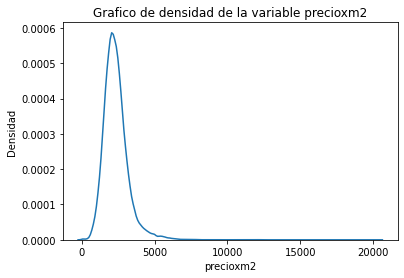

In [463]:
sns_hist = sns.kdeplot(data=ds_clasificacion_train['precioxm2']).set(title="Grafico de densidad de la variable precioxm2", xlabel="precioxm2", ylabel="Densidad")

Grafico la densidad de precioxm2 relativo al tipo de propiedad

Text(0.5, 1.0, 'Densidad del precioxm2 relativo al tipo de propiedad')

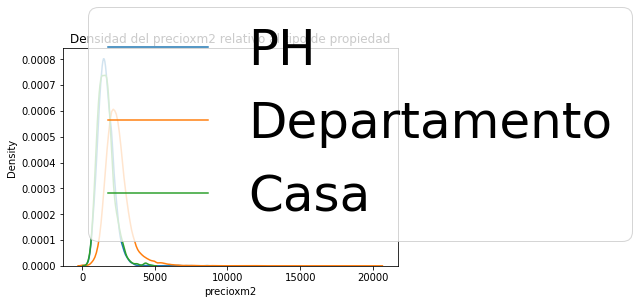

In [464]:
densidad_depto = ds_clasificacion_train[ds_clasificacion_train["property_type"] == "Departamento"]["precioxm2"]
densidad_casa = ds_clasificacion_train[ds_clasificacion_train["property_type"] == "Casa"]["precioxm2"]
densidad_ph = ds_clasificacion_train[ds_clasificacion_train["property_type"] == "PH"]["precioxm2"]
sns.kdeplot(data=densidad_ph, label = "PH")
sns.kdeplot(data=densidad_depto, label="Departamento")
sns.kdeplot(data=densidad_casa, label="Casa")
plt.legend()
plt.title("Densidad del precioxm2 relativo al tipo de propiedad")

#### Igual Frecuencia

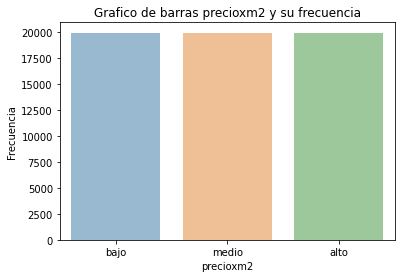

In [465]:
labels=["bajo","medio","alto"]

ds_clasificacion_train["precioxm2_igual_frec"] = pd.qcut(ds_clasificacion_train["precioxm2"],q=3, labels=labels)

#Gráfico de barras con Seaborn
ds_agrupado_precioxm2=ds_clasificacion_train.groupby(['precioxm2_igual_frec']).count()  #Calculo la frecuencia de cada categoría

eje_x = ds_agrupado_precioxm2.index.tolist()   ## Declaramos valores para el eje x
eje_y = ds_agrupado_precioxm2['precioxm2'].tolist()  ## Declaramos valores para el eje y

sns_bar_plot=sns.barplot(x=eje_x, y=eje_y, data=ds_agrupado_precioxm2 ,alpha=0.5).set(title="Grafico de barras precioxm2 y su frecuencia",ylabel='Frecuencia',xlabel='precioxm2')
plt.show()

#### Por cuantiles

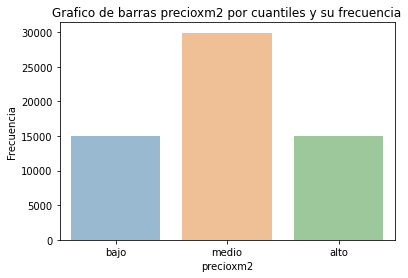

In [466]:
labels=["bajo","medio","alto"]
ds_clasificacion_train["precioxm2_q"] = pd.qcut(ds_clasificacion_train["precioxm2"],q=[0,0.25,0.75,1], labels=labels)

#Gráfico de barras con Seaborn
ds_agrupado_precioxm2 = ds_clasificacion_train.groupby(['precioxm2_q']).count()  #Calculo la frecuencia de cada categoría

eje_x = ds_agrupado_precioxm2.index.tolist()   ## Declaramos valores para el eje x
eje_y = ds_agrupado_precioxm2['precioxm2'].tolist()  ## Declaramos valores para el eje y

sns_bar_plot=sns.barplot(x=eje_x, y=eje_y, data=ds_agrupado_precioxm2 ,alpha=0.5).set(title="Grafico de barras precioxm2 por cuantiles y su frecuencia",ylabel='Frecuencia',xlabel='precioxm2')
plt.show()

#### Por viviendas

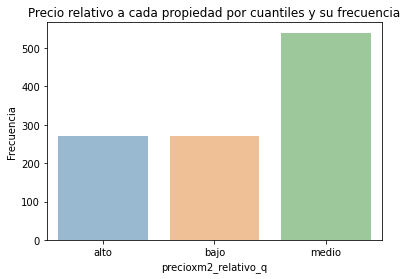

In [467]:

def aplicar_opcion_3(dataset):

    dataset["precioxm2_relativo_q"] = np.nan
    labels=["bajo","medio","alto"]

    #Casa
    dataset.loc[dataset["property_type"] == "Casa", "precioxm2_relativo_q"]=pd.qcut(dataset[dataset["property_type"] == "Casa"]["precioxm2"],q=[0,0.25,0.75,1], labels=labels)

    #Departamento
    dataset.loc[dataset["property_type"] == "Departamento", "precioxm2_relativo_q"]=pd.qcut(dataset[dataset["property_type"] == "Departamento"]["precioxm2"],q=[0,0.25,0.75,1], labels=labels)

    #PH
    dataset.loc[dataset["property_type"] == "PH", "precioxm2_relativo_q"]=pd.qcut(dataset[dataset["property_type"] == "PH"]["precioxm2"],q=[0,0.25,0.75,1], labels=labels)


aplicar_opcion_3(ds_clasificacion_train)

#Gráfico de barras con Seaborn
ds_agrupado_precioxm2=ds_clasificacion_train[ds_clasificacion_train["property_type"] == "Casa"].groupby(['precioxm2_relativo_q']).count()  #Calculo la frecuencia de cada categoría

eje_x = ds_agrupado_precioxm2.index.tolist()   
eje_y = ds_agrupado_precioxm2['precioxm2'].tolist()  

sns_bar_plot=sns.barplot(x=eje_x, y=eje_y, data=ds_agrupado_precioxm2 ,alpha=0.5).set(title="Precio relativo a cada propiedad por cuantiles y su frecuencia",ylabel='Frecuencia',xlabel='precioxm2_relativo_q')
plt.show()

In [468]:
ds_clasificacion_train.head()

,latitud,longitud,place_l3,property_type,property_rooms,property_bedrooms,property_surface_total,property_surface_covered,property_price,precioxm2,precioxm2_igual_frec,precioxm2_q,precioxm2_relativo_q
0,-34.601807,-58.469965,Paternal,Departamento,2.0,1.0,53.0,49.0,80000.0,1509.43,bajo,bajo,bajo
1,-34.580088,-58.424965,Palermo,Departamento,2.0,1.0,35.0,35.0,79900.0,2282.86,medio,medio,medio
2,-34.551481,-58.452358,Belgrano,Departamento,1.0,1.0,25.0,20.0,69000.0,2760.00,alto,alto,medio
3,-34.632290,-58.464844,Flores,Departamento,5.0,3.0,75.0,75.0,150000.0,2000.00,medio,medio,medio
4,-34.549279,-58.463074,Nuñez,Departamento,2.0,1.0,46.0,34.0,85000.0,1847.83,bajo,medio,bajo


#### Seleccion de alternativa

Opcion 1:
- Por lo que podemos observar en los graficos, al distribucion del precioxm2 no es para todas las pripiedades iguales, por lo que la opcion 1 esta descartada

Opcion 2:
- Mismo motivo que la opcion 1 ####

Opcion 3:
- Elegimos esta opcion, dado a que se esta separando por propiedades en quantiles, observando los graficos de densidad, esta es la mejor alternativa

Viendo los resultados notamos que la clasificacion por clusters no es correspondiente a las anteriores clasificaciones ya que no es muy precisa al tomar en cuenta la superficie total ##########################

#### Grafico sobre mapa de Caba

In [469]:
import geopandas
from shapely.geometry import Point

ds_mapa_point = geopandas.GeoDataFrame(ds_clasificacion_train, geometry=geopandas.points_from_xy(ds_clasificacion_train.longitud, ds_clasificacion_train.latitud))
ds_mapa_capital = geopandas.read_file("barrios_2/barrios-polygon.shp")

In [470]:
ds_clasificacion_train.loc[ds_clasificacion_train['precioxm2_q'] == "bajo",'color'] = 1
ds_clasificacion_train.loc[ds_clasificacion_train['precioxm2_q'] == "medio",'color'] = 2
ds_clasificacion_train.loc[ds_clasificacion_train['precioxm2_q'] == "alto",'color'] = 3

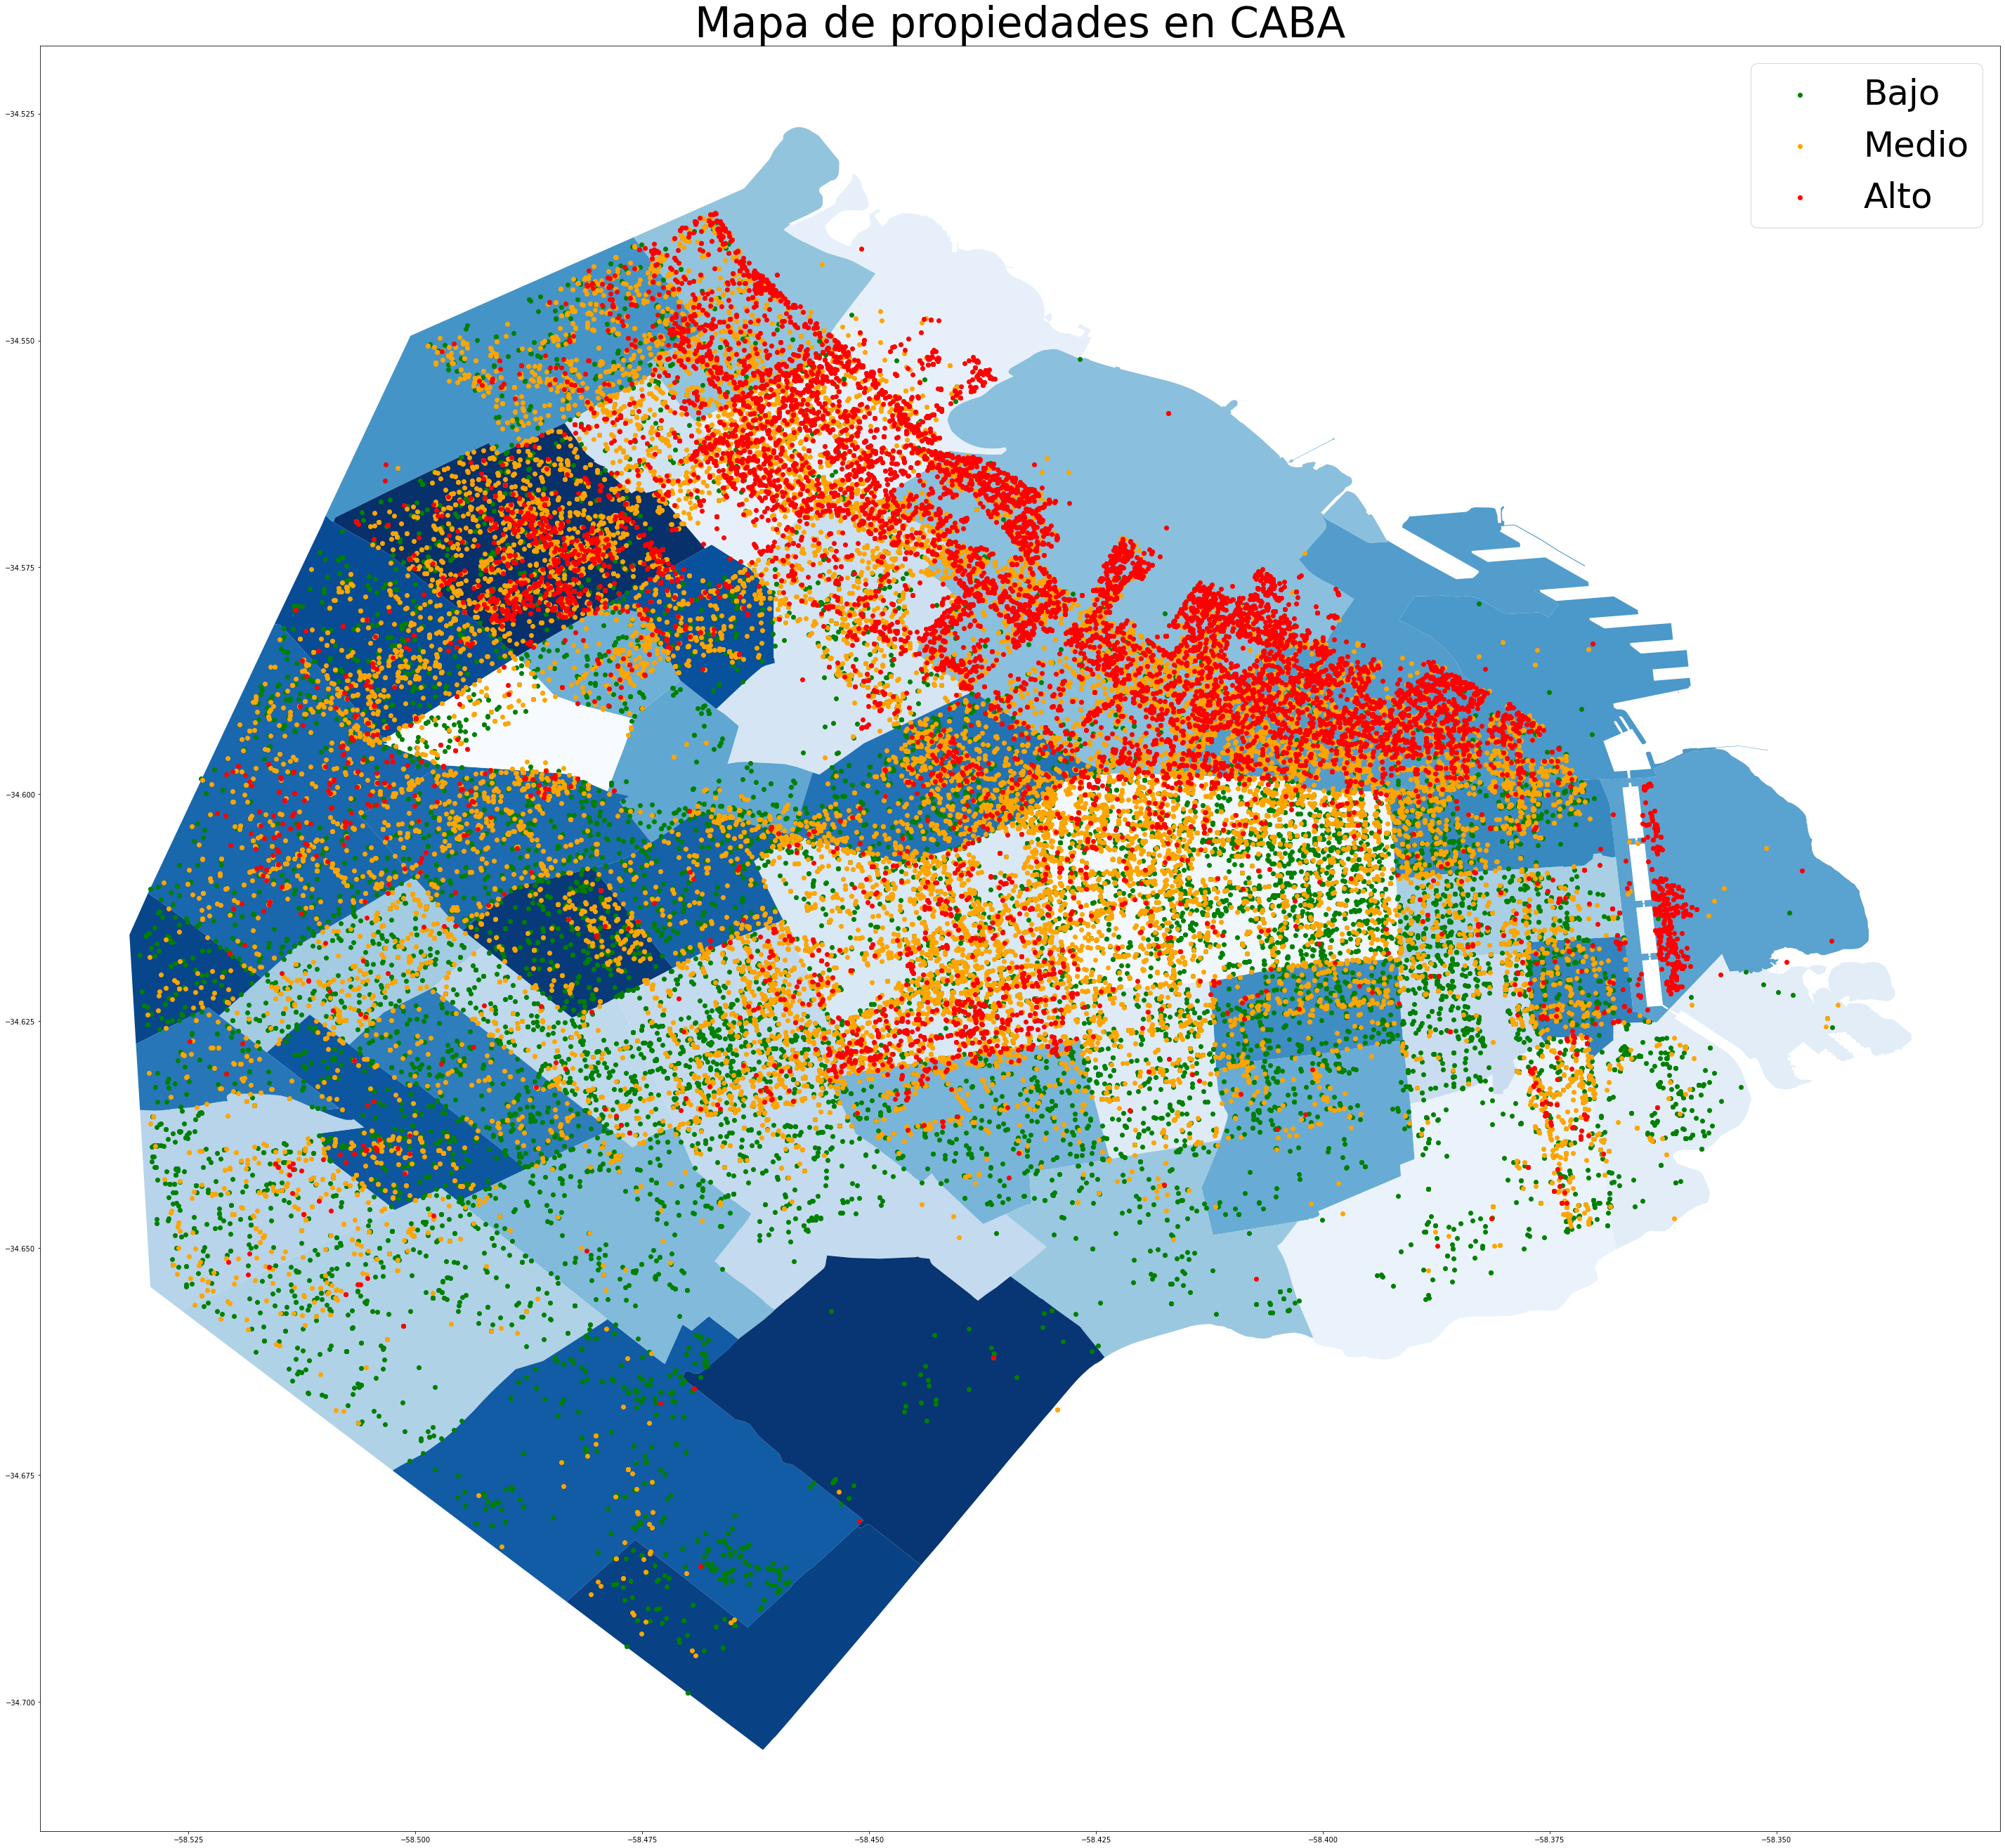

In [471]:

fig,ax = plt.subplots(figsize = (50,50))
ds_mapa_capital.plot(ax = ax, column = "BARRIO", cmap = "Blues")
ds_mapa_point[ds_mapa_point["color"] == 1].plot(ax = ax, color = "green",label="Bajo")
ds_mapa_point[ds_mapa_point["color"] == 2].plot(ax = ax, color = "orange", label = "Medio") 
ds_mapa_point[ds_mapa_point["color"] == 3].plot(ax = ax, color = "red", label="Alto") 
ax.set_title("Mapa de propiedades en CABA", fontdict = {"fontsize" : "60"})
plt.rc('legend', fontsize=50)
plt.legend()
plt.show()

Como podemos observar, las viviendas de mayor valor se ubican en la zona este/norte de la ciudad, lo que es bastante coincidente a la realidad.

# Entrenamiento y Predicción

### Preparo los datasets

#### Datasets completos

In [682]:
#aplico la alternativa seleccionada al dataset de testeo
aplicar_opcion_3(ds_clasificacion_test)

#elimino columnas 
columnas_a_eliminar_train = ["precioxm2_igual_frec", "precioxm2_q", "color", "geometry", "property_price", "precioxm2", "place_l3"]
columnas_a_eliminar_test = ["place_l3", "property_price", "precioxm2"]

#Datasets que utilizamos a lo largo del punto
ds_train = ds_clasificacion_train.drop(columns = columnas_a_eliminar_train)
ds_test = ds_clasificacion_test.drop(columns = columnas_a_eliminar_test)

Predeciccion del valor del atributo tipo_precio,

In [683]:
ds_train.head()

,latitud,longitud,property_type,property_rooms,property_bedrooms,property_surface_total,property_surface_covered,precioxm2_relativo_q
0,-34.601807,-58.469965,Departamento,2.0,1.0,53.0,49.0,bajo
1,-34.580088,-58.424965,Departamento,2.0,1.0,35.0,35.0,medio
2,-34.551481,-58.452358,Departamento,1.0,1.0,25.0,20.0,medio
3,-34.632290,-58.464844,Departamento,5.0,3.0,75.0,75.0,medio
4,-34.549279,-58.463074,Departamento,2.0,1.0,46.0,34.0,bajo


In [684]:
ds_train.shape

(59851, 8)

In [685]:
ds_test.head()

,latitud,longitud,property_type,property_rooms,property_bedrooms,property_surface_total,property_surface_covered,precioxm2_relativo_q
0,-34.598679,-58.499717,Departamento,1.0,1.0,38.0,28.0,medio
1,-34.574987,-58.420611,Departamento,2.0,1.0,150.0,70.0,alto
2,-34.586527,-58.398279,Departamento,2.0,1.0,43.0,41.0,medio
3,-34.577647,-58.406064,Departamento,4.0,3.0,130.0,118.0,alto
4,-34.560998,-58.464248,Departamento,1.0,1.0,33.0,29.0,alto


In [686]:
ds_test.shape

(16262, 8)

Feature engineering

In [687]:
ds_train = pd.get_dummies(ds_train, columns=["property_type"], drop_first=True)
ds_test =  pd.get_dummies(ds_test, columns=["property_type"], drop_first=True)

In [688]:
columnas_elegidas = ['property_rooms', 'property_bedrooms', 'property_surface_total', "property_surface_covered"]
sc = StandardScaler()

#estandarizo variables cuantitativas en train
x = ds_train.loc[:, columnas_elegidas].values
x = sc.fit_transform(x)
ds_train[columnas_elegidas] = x 

#estandarizo variables cuantitativas en test
y = ds_test.loc[:, columnas_elegidas].values
y = sc.transform(y)
ds_test[columnas_elegidas] = y


In [689]:
ds_train.head()

,latitud,longitud,property_rooms,property_bedrooms,property_surface_total,property_surface_covered,precioxm2_relativo_q,property_type_Departamento,property_type_PH
0,-34.601807,-58.469965,-0.575301,-0.904778,-0.357417,-0.422278,bajo,1,0
1,-34.580088,-58.424965,-0.575301,-0.904778,-0.614211,-0.774079,medio,1,0
2,-34.551481,-58.452358,-1.459566,-0.904778,-0.756875,-1.151008,medio,1,0
3,-34.632290,-58.464844,2.077491,1.413169,-0.043558,0.231066,medio,1,0
4,-34.549279,-58.463074,-0.575301,-0.904778,-0.457282,-0.799207,bajo,1,0


#### Datasets reducidos

In [690]:
ds_reducido_train = pd.read_csv("properati_argentina_reducido_train.csv")
ds_reducido_test = pd.read_csv("properati_argentina_reducido_train.csv")

columnas_a_eliminar = ["Unnamed: 0", "target"]

#datasets reducidos que utilizaremos a lo largo del punto
ds_reducido_train.drop(columns=columnas_a_eliminar, inplace=True)
ds_reducido_test.drop(columns=columnas_a_eliminar, inplace=True)

agregamos las columnas de precioxm2_relativo_q

In [691]:
ds_reducido_train["precioxm2_relativo_q"] = ds_clasificacion_train["precioxm2_relativo_q"]
ds_reducido_test["precioxm2_relativo_q"] = ds_clasificacion_test["precioxm2_relativo_q"]

In [692]:
ds_reducido_train.head()

,cp_1,cp_2,cp_3,cp_4,cp_5,cp_6,precioxm2_relativo_q
0,-1.203931,-0.275293,0.413176,0.281218,-0.653813,0.322816,bajo
1,-1.556395,0.103435,0.233243,-0.015272,0.565592,-0.188810,medio
2,-2.230063,-0.194028,1.526780,-0.091470,0.809760,-0.160262,medio
3,1.678872,0.694012,-0.608398,0.044571,-2.015136,-0.732341,medio
4,-1.511679,0.021077,1.780005,-0.186017,0.574209,-0.148672,bajo


In [693]:
ds_reducido_train.shape

(59851, 7)

In [694]:
ds_reducido_test.head()

,cp_1,cp_2,cp_3,cp_4,cp_5,cp_6,precioxm2_relativo_q
0,-1.203931,-0.275293,0.413176,0.281218,-0.653813,0.322816,medio
1,-1.556395,0.103435,0.233243,-0.015272,0.565592,-0.188810,alto
2,-2.230063,-0.194028,1.526780,-0.091470,0.809760,-0.160262,medio
3,1.678872,0.694012,-0.608398,0.044571,-2.015136,-0.732341,alto
4,-1.511679,0.021077,1.780005,-0.186017,0.574209,-0.148672,alto


In [695]:
ds_reducido_test.shape

(59851, 7)

## Arbol de decision

In [696]:
features_normal = ["latitud", "longitud", 'property_rooms', 'property_bedrooms', 'property_surface_total', "property_surface_covered", "property_type_Departamento", "property_type_PH"]

features_reducido = ["cp_1", "cp_2", "cp_3", "cp_4", "cp_5", "cp_6"]

target = ["precioxm2_relativo_q"]

In [697]:
#Verifico balanceo de clases
ds_train[target].value_counts(normalize=True)*100 

precioxm2_relativo_q
medio                   49.945698
bajo                    25.055555
alto                    24.998747
dtype: float64

Si bien los arboles de decision no son normalmente afectados por clases desbalanceadas, es importante tenerlo en cuenta para otros algoritmos de clasificacion

In [698]:
#train
x_train =ds_train[features_normal]
y_train = ds_train[target]

#test
x_test= ds_test[features_normal]
y_test= ds_test[target]

In [699]:
#train reducido
x_train_reducido = ds_reducido_train[features_reducido]
y_train_reducido =  ds_reducido_train[target]

#test reducido
x_test_reducido = ds_reducido_test[features_reducido]
y_test_reducido =  ds_reducido_test[target]

#### Optimizacion de hiperparametros

In [700]:
def optimizar_parametros(ds_train_x, ds_train_y):
    #Cantidad de combinaciones que quiero porbar
    n=10 

    #Conjunto de parámetros que quiero usar
    params_grid = {'criterion':['gini','entropy'],
                'min_samples_leaf':list(range(1,10)),
                'min_samples_split': list(range(12,20)),
                'ccp_alpha':np.linspace(0.001,0.005,n), 
                'max_depth':list(range(5,6))}
                    
    #Cantidad de splits para el Cross Validation
    folds=10

    #Kfold estratificado
    kfoldcv = StratifiedKFold(n_splits=folds)

    #Clasificador
    base_tree = DecisionTreeClassifier() 

    #Metrica que quiero optimizar F1 Score
    scorer_fn = make_scorer(f1_score, average='micro')

    """
    scoring = { 'accuracy' : make_scorer(accuracy_score, avarage="micro"), 
                'precision' : make_scorer(precision_score, avarage="micro"),
                'recall' : make_scorer(recall_score, avarage="micro"), 
                'f1' : make_scorer(sk.metrics.f1_score, average="micro")
                }
    """

    #Random Search Cross Validation
    randomcv = RandomizedSearchCV(estimator=base_tree,
                                param_distributions = params_grid,
                                scoring=scorer_fn,
                                cv=kfoldcv,
                                n_iter=n,
                                random_state=1) 


    return randomcv.fit(ds_train_x,ds_train_y)

randomcv_normal = optimizar_parametros(x_train, y_train)
randomcv_reducido = optimizar_parametros(x_train_reducido, y_train_reducido)

 - Utilizamos Random Serch con 10 combinaciones totales
 - Para k-fold utilizamos 10 folds
 - Para buscar los parametros consideramos utilizar f1-score como metrica


In [701]:
#Mejores hiperparametros del arbol
print("Para el dataset completo, obtuvimos que los mejores hiperparametros del arbol son: " + str(randomcv_normal.best_params_))
#Mejor métrica
print("Y el f1-score que obtuvimos en el dataset completo para los datos de entrenamiento fue de: " + str(randomcv_normal.best_score_))


Para el dataset completo, obtuvimos que los mejores hiperparametros del arbol son: {'min_samples_split': 15, 'min_samples_leaf': 3, 'max_depth': 5, 'criterion': 'entropy', 'ccp_alpha': 0.0014444444444444444}
Y el f1-score que obtuvimos en el dataset completo para los datos de entrenamiento fue de: 0.5760472626046685


In [702]:
#Mejores hiperparametros del arbol
print("Para el dataset reducido, obtuvimos que los mejores hiperparametros del arbol son: " + str(randomcv_reducido.best_params_))
#Mejor métrica
print("Y el f1-score que obtuvimos en el dataset completo para los datos de entrenamiento fue de: " + str(randomcv_reducido.best_score_))


Para el dataset reducido, obtuvimos que los mejores hiperparametros del arbol son: {'min_samples_split': 13, 'min_samples_leaf': 8, 'max_depth': 5, 'criterion': 'entropy', 'ccp_alpha': 0.001}
Y el f1-score que obtuvimos en el dataset completo para los datos de entrenamiento fue de: 0.5636998164193198


Podemos observar como los f1-score de ambos datasets, el reducido y el normal son casi iguales, esto nos indica que la reduccion de la dimension fue util.
Con menos variables, podemos predecir con casi la misma exactitud

Observbamos que variables fueron mas importantes

In [703]:
#Atributos considerados y su importancia
best_tree_normal = randomcv_normal.best_estimator_
feat_imps_normal = best_tree_normal.feature_importances_

for feat_imp,feat in sorted(zip(feat_imps_normal,features_normal)):
  print('{}: {}'.format(feat,feat_imp))

property_bedrooms: 0.0
property_rooms: 0.0
property_surface_covered: 0.0
property_type_PH: 0.0
property_type_Departamento: 0.02356294831981477
property_surface_total: 0.024139367136746574
longitud: 0.25565986317638073
latitud: 0.6966378213670579


In [704]:
#Atributos considerados y su importancia
best_tree_reducido = randomcv_reducido.best_estimator_
feat_imps_reducido = best_tree_reducido.feature_importances_

for feat_imp,feat in sorted(zip(feat_imps_reducido,features_reducido)):
  print('{}: {}'.format(feat,feat_imp))

cp_1: 0.0
cp_4: 0.046907113124953846
cp_6: 0.07845445631216859
cp_2: 0.09196991186175645
cp_3: 0.3642067248933169
cp_5: 0.4184617938078041


In [705]:
#Creo el árbol con los mejores hiperparámetros
def crear_arbol_ideal(random_cv, ds_train_x, ds_train_y, features_param):
    
    arbol = DecisionTreeClassifier().set_params(**random_cv.best_params_)

    #Entreno el arbol en todo el set
    arbol.fit(ds_train_x, ds_train_y)

    return export_text(arbol, feature_names=list(features_param)), arbol

reglas_normal, arbol_normal = crear_arbol_ideal(randomcv_normal, x_train, y_train, features_normal)

reglas_reducido, arbol_reducido = crear_arbol_ideal(randomcv_reducido, x_train_reducido, y_train_reducido, features_reducido)

Imprimo reglas que toma el arbol para clasificar una instancia creado con el dataset completo

In [706]:
print(reglas_normal)

|--- latitud <= -34.60
|   |--- longitud <= -58.37
|   |   |--- longitud <= -58.42
|   |   |   |--- latitud <= -34.63
|   |   |   |   |--- property_type_Departamento <= 0.50
|   |   |   |   |   |--- class: medio
|   |   |   |   |--- property_type_Departamento >  0.50
|   |   |   |   |   |--- class: bajo
|   |   |   |--- latitud >  -34.63
|   |   |   |   |--- longitud <= -58.46
|   |   |   |   |   |--- class: medio
|   |   |   |   |--- longitud >  -58.46
|   |   |   |   |   |--- class: medio
|   |   |--- longitud >  -58.42
|   |   |   |--- property_surface_total <= -0.58
|   |   |   |   |--- class: medio
|   |   |   |--- property_surface_total >  -0.58
|   |   |   |   |--- property_type_Departamento <= 0.50
|   |   |   |   |   |--- class: medio
|   |   |   |   |--- property_type_Departamento >  0.50
|   |   |   |   |   |--- class: bajo
|   |--- longitud >  -58.37
|   |   |--- latitud <= -34.63
|   |   |   |--- class: bajo
|   |   |--- latitud >  -34.63
|   |   |   |--- class: alto
|--- 

In [707]:
print(reglas_reducido)

|--- cp_3 <= -0.92
|   |--- cp_5 <= 0.78
|   |   |--- cp_5 <= 0.45
|   |   |   |--- cp_3 <= -1.07
|   |   |   |   |--- cp_2 <= -2.76
|   |   |   |   |   |--- class: bajo
|   |   |   |   |--- cp_2 >  -2.76
|   |   |   |   |   |--- class: bajo
|   |   |   |--- cp_3 >  -1.07
|   |   |   |   |--- cp_5 <= -0.21
|   |   |   |   |   |--- class: medio
|   |   |   |   |--- cp_5 >  -0.21
|   |   |   |   |   |--- class: bajo
|   |   |--- cp_5 >  0.45
|   |   |   |--- cp_2 <= 1.19
|   |   |   |   |--- cp_2 <= -3.10
|   |   |   |   |   |--- class: medio
|   |   |   |   |--- cp_2 >  -3.10
|   |   |   |   |   |--- class: bajo
|   |   |   |--- cp_2 >  1.19
|   |   |   |   |--- cp_3 <= -1.61
|   |   |   |   |   |--- class: alto
|   |   |   |   |--- cp_3 >  -1.61
|   |   |   |   |   |--- class: bajo
|   |--- cp_5 >  0.78
|   |   |--- cp_2 <= 0.47
|   |   |   |--- cp_6 <= 0.21
|   |   |   |   |--- class: medio
|   |   |   |--- cp_6 >  0.21
|   |   |   |   |--- cp_2 <= 0.16
|   |   |   |   |   |--- class:

Vemos que coincidentemente con la importancia de atributos, en ningun momento utiliza las variables property_bedrooms, property_rooms, property_surface_covered o property_type_PH

#### Grafico el arbol

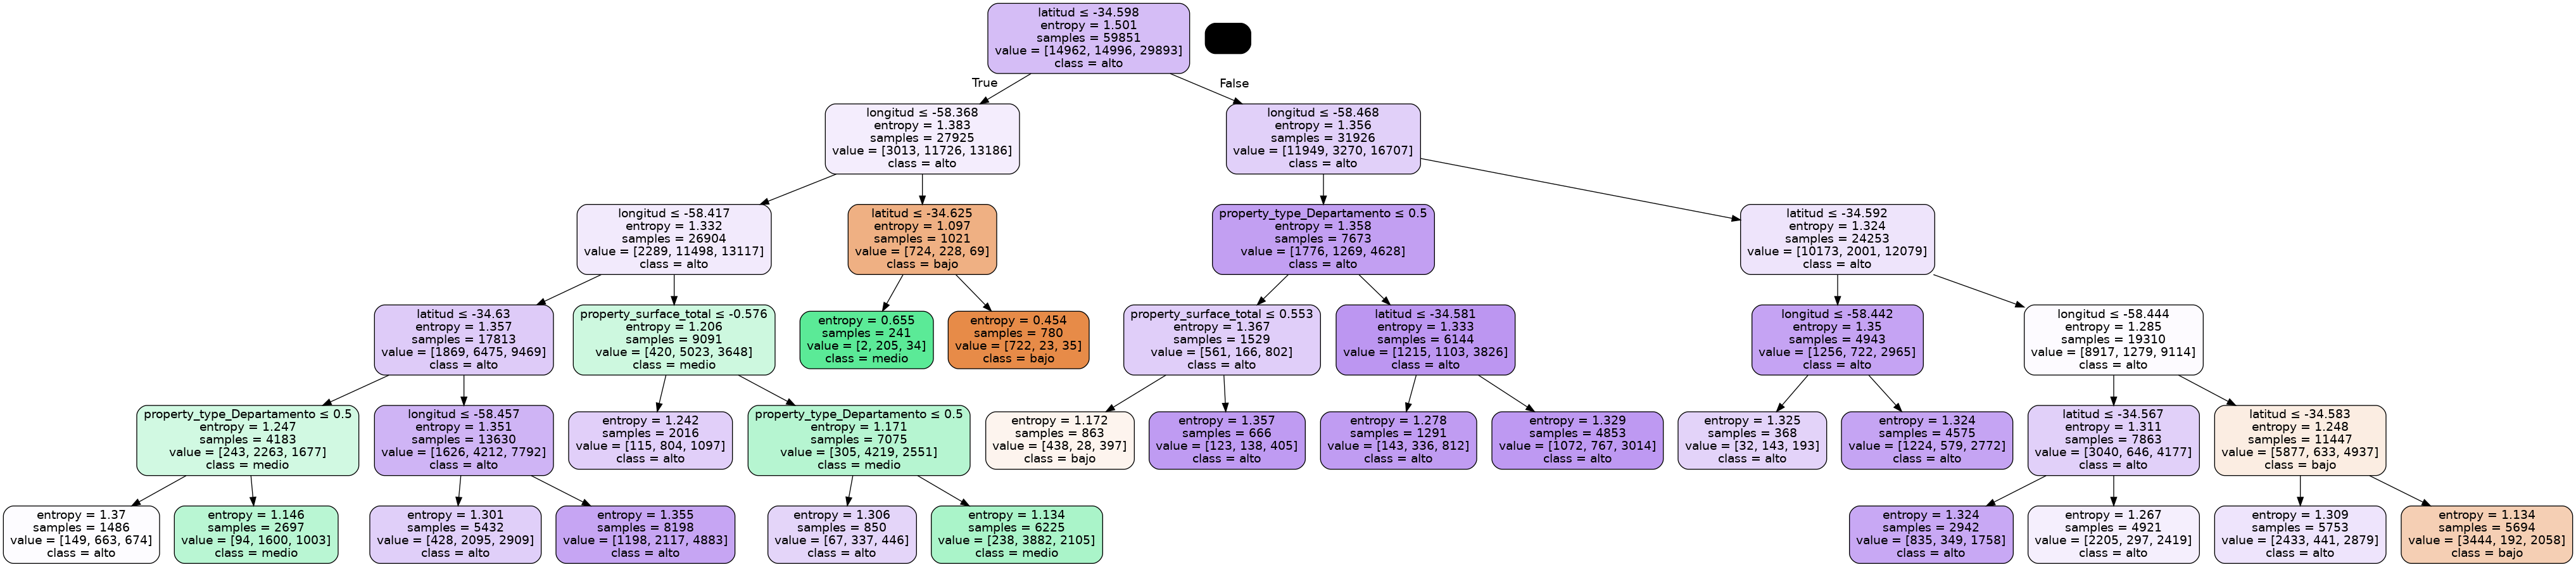

In [708]:
dot_data = StringIO()
export_graphviz(arbol_normal, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True,
                feature_names=features_normal,
                class_names=['bajo','medio','alto'])

graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())

######################################### explicar #############################3

#### Explicacion

#### Evaluo

Dataset normal

              precision    recall  f1-score   support

        alto       0.63      0.30      0.40      4063
        bajo       0.61      0.37      0.46      4067
       medio       0.56      0.81      0.66      8132

    accuracy                           0.57     16262
   macro avg       0.60      0.49      0.51     16262
weighted avg       0.59      0.57      0.55     16262

F1-Score de la prdiccion sobre el set de evaluacion del dataset normal es: 0.5734227032345345


Text(33.0, 0.5, 'True')

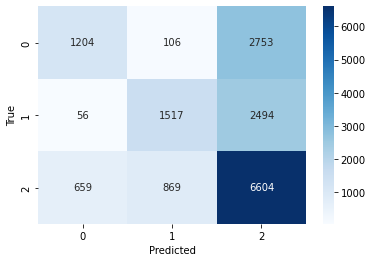

In [734]:
#Evalúo el Arbol con los mejores hiperparámetros

#Hago predicción sobre el set de evaluacion
y_pred = arbol_normal.predict(x_test)

#Arbol Reporte y Matriz de Confusion
print(classification_report(y_test,y_pred))
print('F1-Score de la prdiccion sobre el set de evaluacion del dataset normal es: {}'.format(f1_score(y_test, y_pred, average='micro'))) #binary considera la clase positiva por defecto 1

cm = confusion_matrix(y_test,y_pred)
sns.heatmap(cm, cmap='Blues',annot=True,fmt='g')
plt.xlabel('Predicted')
plt.ylabel('True')

- Como podemos observar, el F1-score en datos de entrenamiento es similar al F1-score con datos nuevos, esto es un buen indicio que el modelo no esta overfiteado.

Dataset reducido

In [735]:
#Evalúo el Arbol con los mejores hiperparámetros

#Hago predicción sobre el set de evaluacion
y_pred = arbol_reducido.predict(x_test_reducido)

#Arbol Reporte y Matriz de Confusion
print(classification_report(y_test_reducido,y_pred))
print('F1-Score de la prdiccion sobre el set de evaluacion del dataset normal es: {}'.format(f1_score(y_test_reducido, y_pred, average='micro'))) #binary considera la clase positiva por defecto 1

cm = confusion_matrix(y_test_reducido, y_pred, labels=arbol_reducido.classes_)
sns.heatmap(cm, cmap='Blues',annot=True,fmt='g')
plt.xlabel('Predicted')
plt.ylabel('True')

TypeError: '<' not supported between instances of 'float' and 'str'

Persistimos el modelo


In [ ]:

#filename = "arbol_decision_model.sav"
#pickle.dump(arbol, open(filename, 'wb'))

# Random Forest


In [ ]:
from sklearn.ensemble import RandomForestClassifier
from scipy.stats import uniform, truncnorm, randint
from scipy.stats import randint as sp_randInt


x_train = ds_clasificacion[features]
x_test = test[features]
y_train= ds_clasificacion[target]
y_test= test[target]



#Cantidad de combinaciones que quiero porbar
n=4

#Conjunto de parámetros que quiero usar
#param_grid_rf = {'n_estimators': randint(4,200),'max_depth': [6,7,8], 'min_samples_split': uniform(0.01, 0.199) }


param_grid_rf = {'criterion':['gini','entropy'],
               'min_samples_leaf':list(range(1,10)),
               'min_samples_split': uniform(0.01, 0.199),
               'ccp_alpha':np.linspace(0,0.15,n), 
               'max_depth':list(range(5,6))}
                






#Cantidad de splits para el Cross Validation
folds=5

#Kfold estratificado
kfoldcv = StratifiedKFold(n_splits=folds)

#Clasificador
base_tree_rf = RandomForestClassifier()#n_estimators=648


#Metrica que quiero optimizar F1 Score
from sklearn.metrics import make_scorer, roc_auc_score, recall_score, matthews_corrcoef, balanced_accuracy_score, accuracy_score
scorer_fn = make_scorer(f1_score, average='micro')

#scoring = {"roc_auc_score": new_auc, "recall": recall, "MCC" : mcc, 'Bal_acc' : bal_acc, "Accuracy": acc }

#scoring = {"roc_auc_score": auc_score, "recall": recall, "MCC" : mcc, 'Bal_acc' : bal_acc, "Accuracy": acc }
#Random Search Cross Validation
randomcv_rf = RandomizedSearchCV(estimator=base_tree_rf,
                              param_distributions = param_grid_rf,
                               cv=kfoldcv,
                            scoring = scorer_fn,
                            n_jobs=-1)
randomcv_rf.fit(x_train,y_train)


randomcv_rf.best_estimator_

NameError: name 'ds_clasificacion' is not defined

In [ ]:
print(randomcv_rf.best_params_)

{'ccp_alpha': 0.0, 'criterion': 'entropy', 'max_depth': 5, 'min_samples_leaf': 9, 'min_samples_split': 0.03213414385662961}


In [ ]:
arbol_rf=DecisionTreeClassifier().set_params(**randomcv_rf.best_params_)

#Entreno el arbol en todo el set
arbol_rf.fit(x_train,y_train)

reglas_rf = export_text(arbol_rf, feature_names=list(features))

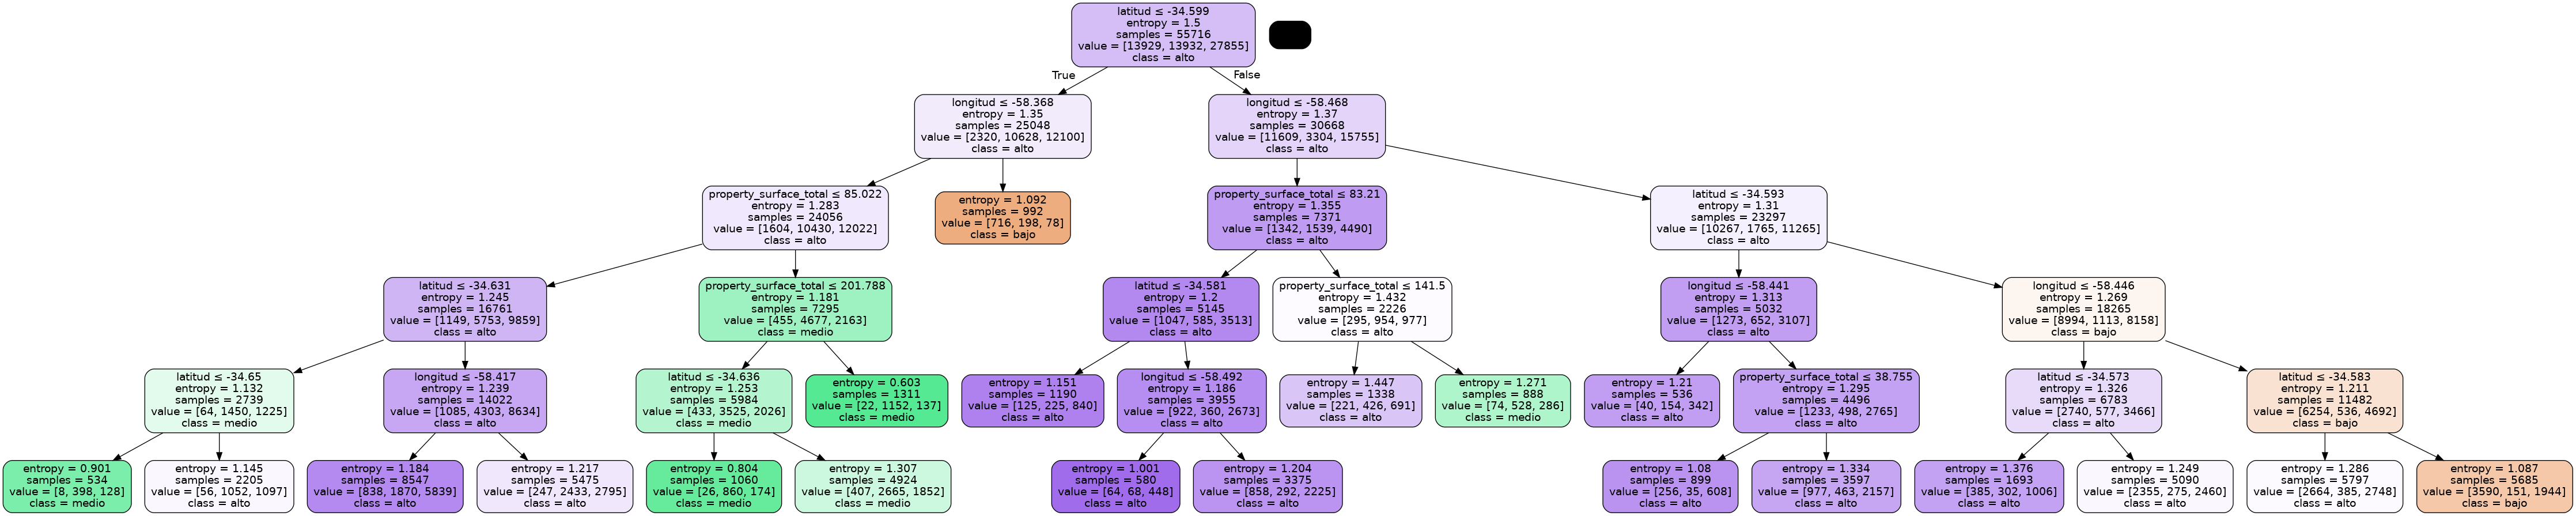

In [ ]:
dot_data = StringIO()
export_graphviz(arbol_rf, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True,
                feature_names=features,
                class_names=['bajo','medio','alto'])

graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())

F1-Score: 0.5970995764232896


Text(33.0, 0.5, 'True')

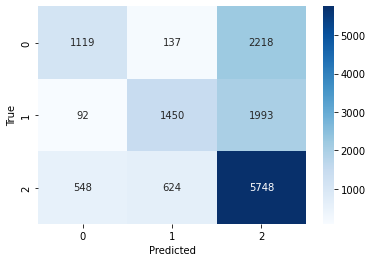

In [ ]:
#Hago predicción sobre el set de evaluacion
y_pred= arbol_rf.predict(x_test)

#Arbol Reporte y Matriz de Confusion
print(classification_report(y_test,y_pred))
print('F1-Score: {}'.format(f1_score(y_test, y_pred, average='micro'))) #binary considera la clase positiva por defecto 1

cm = confusion_matrix(y_test,y_pred)
sns.heatmap(cm, cmap='Blues',annot=True,fmt='g')
plt.xlabel('Predicted')
plt.ylabel('True')

Persistimos el modelo

In [ ]:
#filename = "random_forest_model.sav"
#pickle.dump(arbol_rf, open(filename, 'wb'))

# KNneighborts

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

#Clasificador
knn=KNeighborsClassifier(n_neighbors=1)



knn.fit(x_train,y_train)



KNeighborsClassifier(n_neighbors=1)

In [ ]:
y_pred_knn= knn.predict(x_test)

In [ ]:
result = confusion_matrix(y_test, y_pred_knn)

Text(33.0, 0.5, 'True')

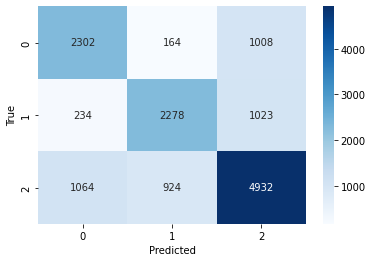

In [ ]:
sns.heatmap(result, cmap='Blues',annot=True,fmt='g')
plt.xlabel('Predicted')
plt.ylabel('True')

In [ ]:
print('F1-Score: {}'.format(f1_score(y_test, y_pred_knn, average='micro'))) #binary considera la clase positiva por defecto 1


F1-Score: 0.6828918084571757


In [ ]:
from sklearn.model_selection import cross_val_score
cv_scores = cross_val_score(knn, x_train, y_train, cv=15)

In [ ]:
#create a dictionary of all values we want to test for n_neighbors
param_grid = {'n_neighbors': np.arange(1, 35)}
#use gridsearch to test all values for n_neighbors
knn_2=KNeighborsClassifier()
knn_gscv = GridSearchCV(knn_2, param_grid, cv=5)
knn_gscv.fit(x_train, y_train)
knn_gscv.best_params_

{'n_neighbors': 1}

In [ ]:
print("cv_scores mean:{}".format(np.mean(cv_scores)))

cv_scores mean:0.6783688264525024


Persistimos el modelo

In [ ]:
#filename = "knn_model.sav"
#pickle.dump(knn_gscv, open(filename, 'wb'))